# Visualiser for area28 metric data

In [303]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [330]:
# df = pd.read_json("data.json")
df = pd.read_csv("dummy.csv")
df = df.set_index('id')
df

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
1,CORE_SCENE_JOIN,0,0,4,2020-01-03 10:41:38,{'rating': None}
2,CORE_SCENE_LEAVE,0,0,4,2020-01-03 11:52:49,{'rating': None}
3,CORE_SCENE_JOIN,1,0,4,2020-01-03 10:45:19,{'rating': None}
4,CORE_SCENE_LEAVE,1,0,4,2020-01-03 15:05:53,{'rating': None}
5,CORE_SCENE_RATE,1,0,4,2020-01-03 15:06:59,{'rating': 2}
...,...,...,...,...,...,...
167,CORE_SCENE_JOIN,8,6,8,2020-01-09 10:35:12,{'rating': None}
168,CORE_SCENE_LEAVE,8,6,8,2020-01-09 13:30:06,{'rating': None}
169,CORE_SCENE_RATE,8,6,8,2020-01-09 13:30:11,{'rating': 3}


In [331]:
import calendar

df_no_rating = df.drop(df[df['type'] == "CORE_SCENE_RATE"].index)

df_no_rating['datetime'] = [dt.datetime.strptime(str(d), '%Y-%m-%d %H:%M:%S') for d in df_no_rating['timestamp']]
durations = df_no_rating.groupby(['userId', 'sessionId'])['datetime'].diff()
df_no_rating['date'] = [dt.datetime.date(d) for d in df_no_rating['datetime']] 
df_no_rating['time'] = [dt.datetime.time(d) for d in df_no_rating['datetime']]
df_no_rating['weekday'] = [calendar.day_name[d.weekday()] for d in df_no_rating['datetime']]

df_no_rating['duration'] = durations
df_processed = df_no_rating[['userId', 'sessionId', 'date', 'duration', 'time', 'weekday', 'sceneId']].copy()
df_processed = df_processed.dropna()
df_processed

,userId,sessionId,date,duration,time,weekday,sceneId
id,,,,,,,
2,0,0,2020-01-03,0 days 01:11:11,11:52:49,Friday,4
4,1,0,2020-01-03,0 days 04:20:34,15:05:53,Friday,4
7,2,0,2020-01-03,0 days 02:18:14,12:39:51,Friday,4
10,3,0,2020-01-03,0 days 04:16:48,15:07:56,Friday,4
13,4,0,2020-01-03,0 days 03:34:51,15:32:52,Friday,4
...,...,...,...,...,...,...,...
161,5,6,2020-01-09,0 days 04:30:04,16:45:24,Thursday,8
163,6,6,2020-01-09,0 days 01:33:48,13:28:25,Thursday,8
165,7,6,2020-01-09,0 days 04:58:51,15:24:06,Thursday,8


In [332]:
df_no_rating.head()

,type,userId,sessionId,sceneId,timestamp,data,datetime,date,time,weekday,duration
id,,,,,,,,,,,
1,CORE_SCENE_JOIN,0,0,4,2020-01-03 10:41:38,{'rating': None},2020-01-03 10:41:38,2020-01-03,10:41:38,Friday,NaT
2,CORE_SCENE_LEAVE,0,0,4,2020-01-03 11:52:49,{'rating': None},2020-01-03 11:52:49,2020-01-03,11:52:49,Friday,0 days 01:11:11
3,CORE_SCENE_JOIN,1,0,4,2020-01-03 10:45:19,{'rating': None},2020-01-03 10:45:19,2020-01-03,10:45:19,Friday,NaT
4,CORE_SCENE_LEAVE,1,0,4,2020-01-03 15:05:53,{'rating': None},2020-01-03 15:05:53,2020-01-03,15:05:53,Friday,0 days 04:20:34
6,CORE_SCENE_JOIN,2,0,4,2020-01-03 10:21:37,{'rating': None},2020-01-03 10:21:37,2020-01-03,10:21:37,Friday,NaT


In [307]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install ipywidgets -q

In [308]:
import ipywidgets as widgets
menu = widgets.Dropdown(
       options=['Day', 'Week', 'Month', 'Year', 'All Time'],
       value='Week',
       description='Timeframe:')
menu

Dropdown(description='Timeframe:', index=1, options=('Day', 'Week', 'Month', 'Year', 'All Time'), value='Week'…

In [309]:
menu.value

'Week'

# Pie chart of time spent in different scenes

In [310]:
df_sessions = pd.DataFrame({'duration' : df_processed.groupby( [ "sceneId"] )['duration'].sum()}).reset_index()
df_sessions['duration_sec'] = [d.total_seconds() for d in df_sessions['duration']]
df_sessions

,sceneId,duration,duration_sec
0,0,0 days 23:03:17,82997.0
1,4,1 days 05:43:47,107027.0
2,7,2 days 01:57:55,179875.0
3,8,1 days 10:36:16,124576.0
4,9,0 days 14:43:43,53023.0
5,12,1 days 01:58:32,93512.0


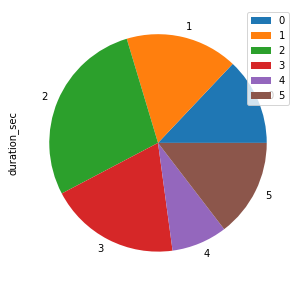

In [311]:
plot = df_sessions.plot.pie(y='duration_sec', figsize=(5, 5))

### Bar Chart showing how long users spent in sessions

<BarContainer object of 70 artists>

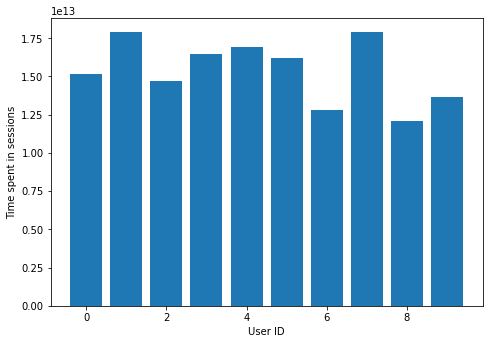

In [312]:
# df_processed.plot(x="userId", y=["times"])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_ylabel('Time spent in sessions')
ax.set_xlabel('User ID')
ax.bar(df_processed['userId'], df_processed['duration'])

# Heatmap showing time spent in session for each user during a week

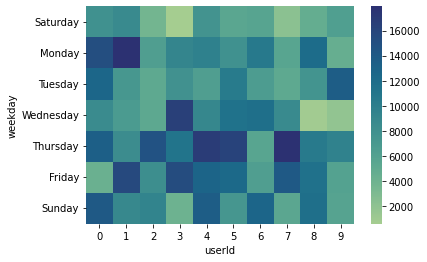

In [313]:
from pandas import DataFrame
import seaborn as sns
import time
%matplotlib inline

df_processed['seconds'] = [d.total_seconds() for d in df_processed['duration']]

df_processed_groupedbyID = pd.DataFrame({'seconds' : df_processed.groupby(['userId', 'weekday'])['seconds'].sum()}).reset_index()

df_heatmap = df_processed_groupedbyID.pivot(index='weekday', columns='userId', values='seconds')
df_heatmap.index = pd.CategoricalIndex(df_heatmap.index, categories= ['Saturday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
df_heatmap.sort_index(level=0, inplace=True)

sns.heatmap(df_heatmap, annot=False, fmt="g", cmap='crest')
plt.show()

In [279]:
df_processed_groupedbyID.head()


,userId,weekday,seconds
0,0,Friday,152390.0
1,0,Monday,96210.0
2,0,Saturday,193095.0
3,0,Sunday,192094.0
4,0,Thursday,115234.0


## Show ratings of users


In [280]:
df_rating = df.drop(df[df['type'] != "CORE_SCENE_RATE"].index)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,data
id,,,,,,
3,CORE_SCENE_RATE,0,0,1,2020-01-03 14:10:17,{'rating': 2}
12,CORE_SCENE_RATE,4,0,1,2020-01-03 16:49:11,{'rating': 3}
17,CORE_SCENE_RATE,6,0,1,2020-01-03 14:05:53,{'rating': 2}
20,CORE_SCENE_RATE,7,0,1,2020-01-03 15:07:17,{'rating': 4}
23,CORE_SCENE_RATE,8,0,1,2020-01-03 12:49:33,{'rating': 3}


In [281]:
import ast
df_rating['data_str'] = [ast.literal_eval(str(d)) for d in df_rating['data']]
df_rating['rating'] = [d['rating'] for d in df_rating['data_str']]
df_rating = df_rating.drop('data', axis=1)
df_rating = df_rating.drop('data_str', axis=1)
df_rating.head()

,type,userId,sessionId,sceneId,timestamp,rating
id,,,,,,
3,CORE_SCENE_RATE,0,0,1,2020-01-03 14:10:17,2
12,CORE_SCENE_RATE,4,0,1,2020-01-03 16:49:11,3
17,CORE_SCENE_RATE,6,0,1,2020-01-03 14:05:53,2
20,CORE_SCENE_RATE,7,0,1,2020-01-03 15:07:17,4
23,CORE_SCENE_RATE,8,0,1,2020-01-03 12:49:33,3


In [282]:
df_rating_grouped = pd.DataFrame({'temp' : df_rating.groupby(["rating"])['type']}).reset_index()
df_rating_grouped['count'] = [len(d[1]) for d in df_rating_grouped['temp']]
df_rating_grouped = df_rating_grouped.drop('temp', axis=1)
df_rating_grouped.columns = ['rating', 'count']
df_rating_grouped


,rating,count
0,0,3
1,1,27
2,2,82
3,3,179
4,4,160
5,5,51


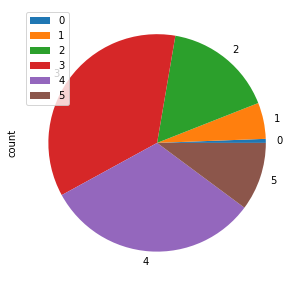

In [283]:
plot = df_rating_grouped.plot.pie(y='count', figsize=(5, 5))

# Histograms

In [338]:
def get_times_active(row):
    end = row['time'].hour
    start = row['time'].hour - row['duration'].seconds//3600
    return_set = set()
    for i in range(end - start + 1):
        return_set.add(str(start + i))
    return return_set

df_processed['hours_active'] = df_processed.apply(get_times_active, axis=1) 
df_processed

,userId,sessionId,date,duration,time,weekday,sceneId,hours_active
id,,,,,,,,
2,0,0,2020-01-03,0 days 01:11:11,11:52:49,Friday,4,"{11, 10}"
4,1,0,2020-01-03,0 days 04:20:34,15:05:53,Friday,4,"{15, 11, 14, 13, 12}"
7,2,0,2020-01-03,0 days 02:18:14,12:39:51,Friday,4,"{11, 12, 10}"
10,3,0,2020-01-03,0 days 04:16:48,15:07:56,Friday,4,"{15, 11, 14, 13, 12}"
13,4,0,2020-01-03,0 days 03:34:51,15:32:52,Friday,4,"{15, 14, 13, 12}"
...,...,...,...,...,...,...,...,...
161,5,6,2020-01-09,0 days 04:30:04,16:45:24,Thursday,8,"{15, 14, 13, 16, 12}"
163,6,6,2020-01-09,0 days 01:33:48,13:28:25,Thursday,8,"{13, 12}"
165,7,6,2020-01-09,0 days 04:58:51,15:24:06,Thursday,8,"{15, 11, 14, 13, 12}"


In [393]:
df_pre_fri_hist = df_processed.loc[df_processed['weekday'] == 'Monday']
df_pre_fri_hist

,userId,sessionId,date,duration,time,weekday,sceneId,hours_active
id,,,,,,,,
77,0,3,2020-01-06,0 days 04:12:41,15:56:28,Monday,7,"{15, 11, 14, 13, 12}"
80,1,3,2020-01-06,0 days 04:58:48,16:18:26,Monday,7,"{15, 14, 13, 16, 12}"
82,2,3,2020-01-06,0 days 01:46:26,12:33:48,Monday,7,"{11, 12}"
84,3,3,2020-01-06,0 days 02:33:37,13:36:01,Monday,7,"{11, 13, 12}"
87,4,3,2020-01-06,0 days 02:43:00,14:06:14,Monday,7,"{14, 13, 12}"
90,5,3,2020-01-06,0 days 02:12:25,12:14:12,Monday,7,"{11, 12, 10}"
93,6,3,2020-01-06,0 days 02:57:27,13:16:44,Monday,7,"{11, 13, 12}"
95,7,3,2020-01-06,0 days 01:34:23,13:31:54,Monday,7,"{13, 12}"
98,8,3,2020-01-06,0 days 03:21:00,14:03:10,Monday,7,"{11, 14, 13, 12}"


In [394]:
data_for_hist = {}
            
count = 0
for times in df_pre_fri_hist['hours_active']:
    for time in times:
        data_for_hist[count] = float(time)
        count += 1
    
df_fri_hist = pd.DataFrame(data_for_hist, index = [0])
df_fri_hist = df_fri_hist.reindex(sorted(df_fri_hist.columns), axis=1)
df_fri_hist

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,15.0,11.0,14.0,13.0,12.0,15.0,14.0,13.0,16.0,12.0,...,13.0,12.0,13.0,12.0,11.0,14.0,13.0,12.0,11.0,12.0


In [399]:
df_fri_hist.max(axis=1)[0]

16.0

## Histogram showing concurrent users throughout a day

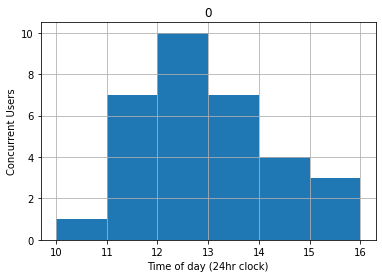

In [404]:
axarr = df_fri_hist.transpose().hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Time of day (24hr clock)")
    ax.set_ylabel("Concurrent Users")

## Histogram showing length of sessions

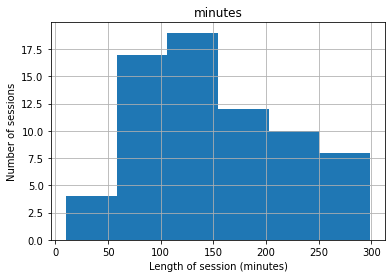

In [430]:
df_sesh_len_hist = df_processed[['duration']].copy()
df_sesh_len_hist['minutes'] = [d.total_seconds()/60 for d in df_processed['duration']]
df_min_hist = df_sesh_len_hist[['minutes']].copy()
axarr = df_min_hist.hist(bins=6)

for ax in axarr.flatten():
    ax.set_xlabel("Length of session (minutes)")
    ax.set_ylabel("Number of sessions")

In [284]:
dt.datetime.now().timestamp()

1636339105.303118

In [ ]:
# histogram showing concurrent users in a scene (throughout day)
# smiley face rating for users to rate the session (store in data)
# histogram showing length of session for users in a week (timeframe)